In [2]:
#Similar Players by Metrics

from nba_api.stats.endpoints import PlayerEstimatedMetrics, CommonPlayerInfo
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import timeas

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]

# Select relevant columns (metrics only)
metrics_columns = [
    "PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
    "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_TOV_PCT", "E_USG_PCT"
]

# Clean the data (drop rows with missing values)
metrics_data = metrics_data[metrics_columns].dropna()

# Filter for players who play at least 35 minutes per game
metrics_data = metrics_data[metrics_data["MIN"] >= 35].reset_index(drop=True)  # Reset index after filtering

# Function to get player position and assign dummy code
def get_position_code(player_id):
    position_mapping = {
        "Guard": 1.5,
        "Guard-Forward": 3,
        "Forward": 4,
        "Forward-Center": 4.5,
        "Center": 5
    }
    
    try:
        player_info = CommonPlayerInfo(player_id=player_id).get_data_frames()[0]
        position = player_info.loc[0, "POSITION"]
        return position_mapping.get(position, 3)  # Default to 3 if position is unknown
    except:
        return 3  # Default category

# Apply the function to get position codes (with a delay to avoid rate limits)
position_codes = []
for pid in metrics_data["PLAYER_ID"]:
    position_codes.append(get_position_code(pid))
    time.sleep(0.6)  # Prevent hitting API rate limits

# Add position codes to the dataframe
metrics_data["POSITION_CODE"] = position_codes

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(metrics_data.iloc[:, 3:])  # Exclude PLAYER_ID, MIN, and PLAYER_NAME from scaling

# Apply Nearest Neighbors
k_neighbors = 15  # Change this to find more or fewer similar players
nn = NearestNeighbors(n_neighbors=k_neighbors, metric="euclidean")
nn.fit(scaled_features)

# Function to find similar players
def find_similar_players(player_name, data, model, num_neighbors=5):
    idx = data.index[data["PLAYER_NAME"] == player_name].tolist()
    if not idx:
        return f"Player '{player_name}' not found."

    distances, indices = model.kneighbors([scaled_features[idx[0]]])  # Ensure indices are correctly mapped
    similar_players = data.iloc[indices[0]]["PLAYER_NAME"].tolist()

    return similar_players

# Example: Find 5 most similar players to a given player
player_name = "Jalen Brunson"  # Change to any player
similar_players = find_similar_players(player_name, metrics_data, nn, k_neighbors)
print(f"Players similar to {player_name}: {similar_players}")


Players similar to Jalen Brunson: ['Jalen Brunson', 'Damian Lillard', 'Devin Booker', "De'Aaron Fox", 'Tyrese Maxey', 'Kyrie Irving', 'Jamal Murray', 'Tyler Herro', 'DeMar DeRozan', 'Trae Young', 'Anthony Edwards', 'Mikal Bridges', 'Cade Cunningham', 'Kevin Durant', 'Jaylen Brown']


In [92]:
# Similar Players By Metrics and Per Game Stats

from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

# Merge datasets on PLAYER_ID
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

# Drop unnecessary columns
merged_data = merged_data.drop(columns=["PLAYER_ID", "PTS", "GP", "REB", "BLK", "STL", "AST"])  # Keeping only per-game stats

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data.iloc[:, 1:])  # Exclude PLAYER_NAME from scaling

# Apply Nearest Neighbors
k_neighbors = 15  # Change this to find more or fewer similar players
nn = NearestNeighbors(n_neighbors=k_neighbors, metric="euclidean")
nn.fit(scaled_features)

# Function to find similar players
def find_similar_players(player_name, data, model, num_neighbors=5):
    idx = data.index[data["PLAYER_NAME"] == player_name].tolist()
    if not idx:
        return f"Player '{player_name}' not found."
    
    distances, indices = model.kneighbors([scaled_features[idx[0]]])
    similar_players = data.iloc[indices[0], :]["PLAYER_NAME"].tolist()
    
    return similar_players

# Example: Find 5 most similar players to a given player
player_name = "Giannis Antetokounmpo"  # Change to any player
similar_players = find_similar_players(player_name, merged_data, nn, k_neighbors)
print(f"Players similar to {player_name}: {similar_players}")


Players similar to Giannis Antetokounmpo: ['Giannis Antetokounmpo', 'Alperen Sengun', 'Anthony Davis', 'Joel Embiid', 'Zion Williamson', 'Karl-Anthony Towns', 'Jalen Johnson', 'Evan Mobley', 'Paolo Banchero', 'Bam Adebayo', 'Scottie Barnes', 'Ivica Zubac', 'Domantas Sabonis', 'Nikola Vučević', 'LeBron James']


In [234]:
# Similar Players By Shooting & Defense

from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "E_OFF_RATING", "E_DEF_RATING", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG3A", "GP", "PTS", "STL", "BLK"]

# Merge datasets on PLAYER_ID
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]

# Drop unnecessary columns
merged_data = merged_data.drop(columns=["PLAYER_ID", "PTS", "GP"])  # Keeping only per-game stats

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data.iloc[:, 1:])  # Exclude PLAYER_NAME from scaling

# Apply Nearest Neighbors
k_neighbors = 15  # Change this to find more or fewer similar players
nn = NearestNeighbors(n_neighbors=k_neighbors, metric="euclidean")
nn.fit(scaled_features)

# Function to find similar players
def find_similar_players(player_name, data, model, num_neighbors=5):
    idx = data.index[data["PLAYER_NAME"] == player_name].tolist()
    if not idx:
        return f"Player '{player_name}' not found."
    
    distances, indices = model.kneighbors([scaled_features[idx[0]]])
    similar_players = data.iloc[indices[0], :]["PLAYER_NAME"].tolist()
    
    return similar_players

# Example: Find 5 most similar players to a given player
player_name = "Derrick White"  # Change to any player
similar_players = find_similar_players(player_name, merged_data, nn, k_neighbors)
print(f"Players similar to {player_name}: {similar_players}")

Players similar to Derrick White: ['Derrick White', 'Naz Reid', 'Tyrese Haliburton', 'Klay Thompson', 'OG Anunoby', 'Mikal Bridges', 'Keegan Murray', 'James Harden', 'Michael Porter Jr.', 'Payton Pritchard', 'Jalen Green', 'Stephen Curry', 'Buddy Hield', 'Trey Murphy III', 'Austin Reaves']


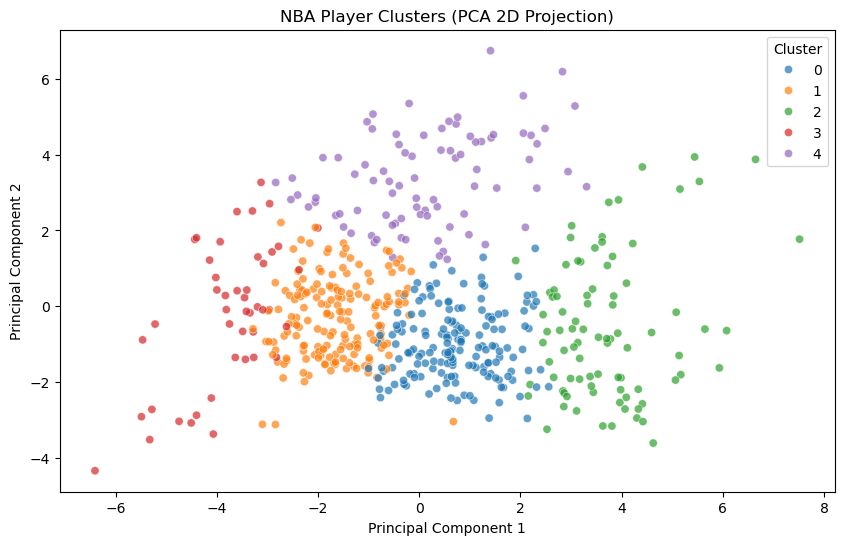

        PLAYER_NAME  Cluster
0    Jamaree Bouyea        1
1     James Wiseman        1
2    Tristen Newton        3
3      Jack McVeigh        1
4      N'Faly Dante        4
..              ...      ...
554  Ulrich Chomche        3
555   Justin Minaya        3
556  Daniss Jenkins        3
557     Zyon Pullin        3
558     P.J. Tucker        1

[559 rows x 2 columns]


In [192]:
from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

# Merge datasets on PLAYER_ID
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")

# Filter for players who play at least x minutes per game
#merged_data = merged_data[merged_data["MIN"] >= 15]

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

# Drop unnecessary columns
merged_data = merged_data.drop(columns=["PLAYER_ID", "PTS", "GP", "REB", "BLK", "STL", "AST"])  # Keeping only per-game stats

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data.iloc[:, 1:])  # Exclude PLAYER_NAME from scaling

# Apply K-Means clustering
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
merged_data["Cluster"] = kmeans.fit_predict(scaled_features)

# Apply PCA for visualization (reduce to 2D)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Convert PCA results into a DataFrame
pca_df = pd.DataFrame(pca_features, columns=["PC1", "PC2"])
pca_df["Cluster"] = merged_data["Cluster"]
pca_df["PLAYER_NAME"] = merged_data["PLAYER_NAME"]

# Plot PCA clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", alpha=0.7)
plt.title("NBA Player Clusters (PCA 2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Display cluster assignments
print(merged_data[["PLAYER_NAME", "Cluster"]])


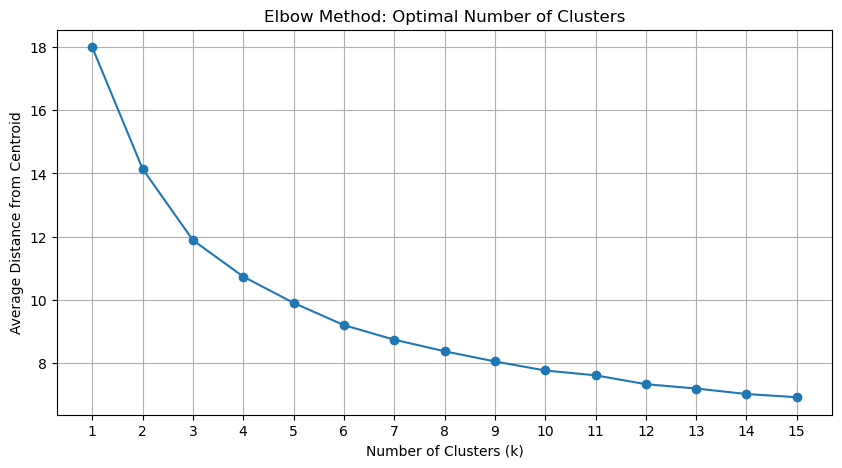


PCA Loadings (How each stat contributes to PC1 and PC2):
                   PC1       PC2
MIN           0.007632  0.403985
E_OFF_RATING  0.025039  0.297182
E_DEF_RATING -0.042940 -0.138585
E_NET_RATING  0.040847  0.280355
E_AST_RATIO  -0.078792  0.094709
E_OREB_PCT    0.392570 -0.086672
E_DREB_PCT    0.389926  0.074950
E_REB_PCT     0.419840  0.023969
E_TOV_PCT     0.138008 -0.038947
E_USG_PCT    -0.007870  0.351470
FG3M         -0.247660  0.260910
FG3_PCT      -0.273908  0.135505
FG_PCT        0.323825  0.085453
PPG           0.019727  0.432058
RPG           0.386452  0.165875
BPG           0.303157  0.050974
SPG          -0.039623  0.259286
APG          -0.060286  0.353835

Outliers by Z-score (> 2.5 SD from centroid):

Cluster 0 Outliers (Z > 2.5):
  Jusuf Nurkić - Distance: 4.86 (Z = 2.53)

Cluster 2 Outliers (Z > 2.5):
  Taylor Hendricks - Distance: 5.86 (Z = 2.52)
  Marcus Bagley - Distance: 6.37 (Z = 2.95)

Cluster 4 Outliers (Z > 2.5):
  Elfrid Payton - Distance: 6.19 (Z = 3.0

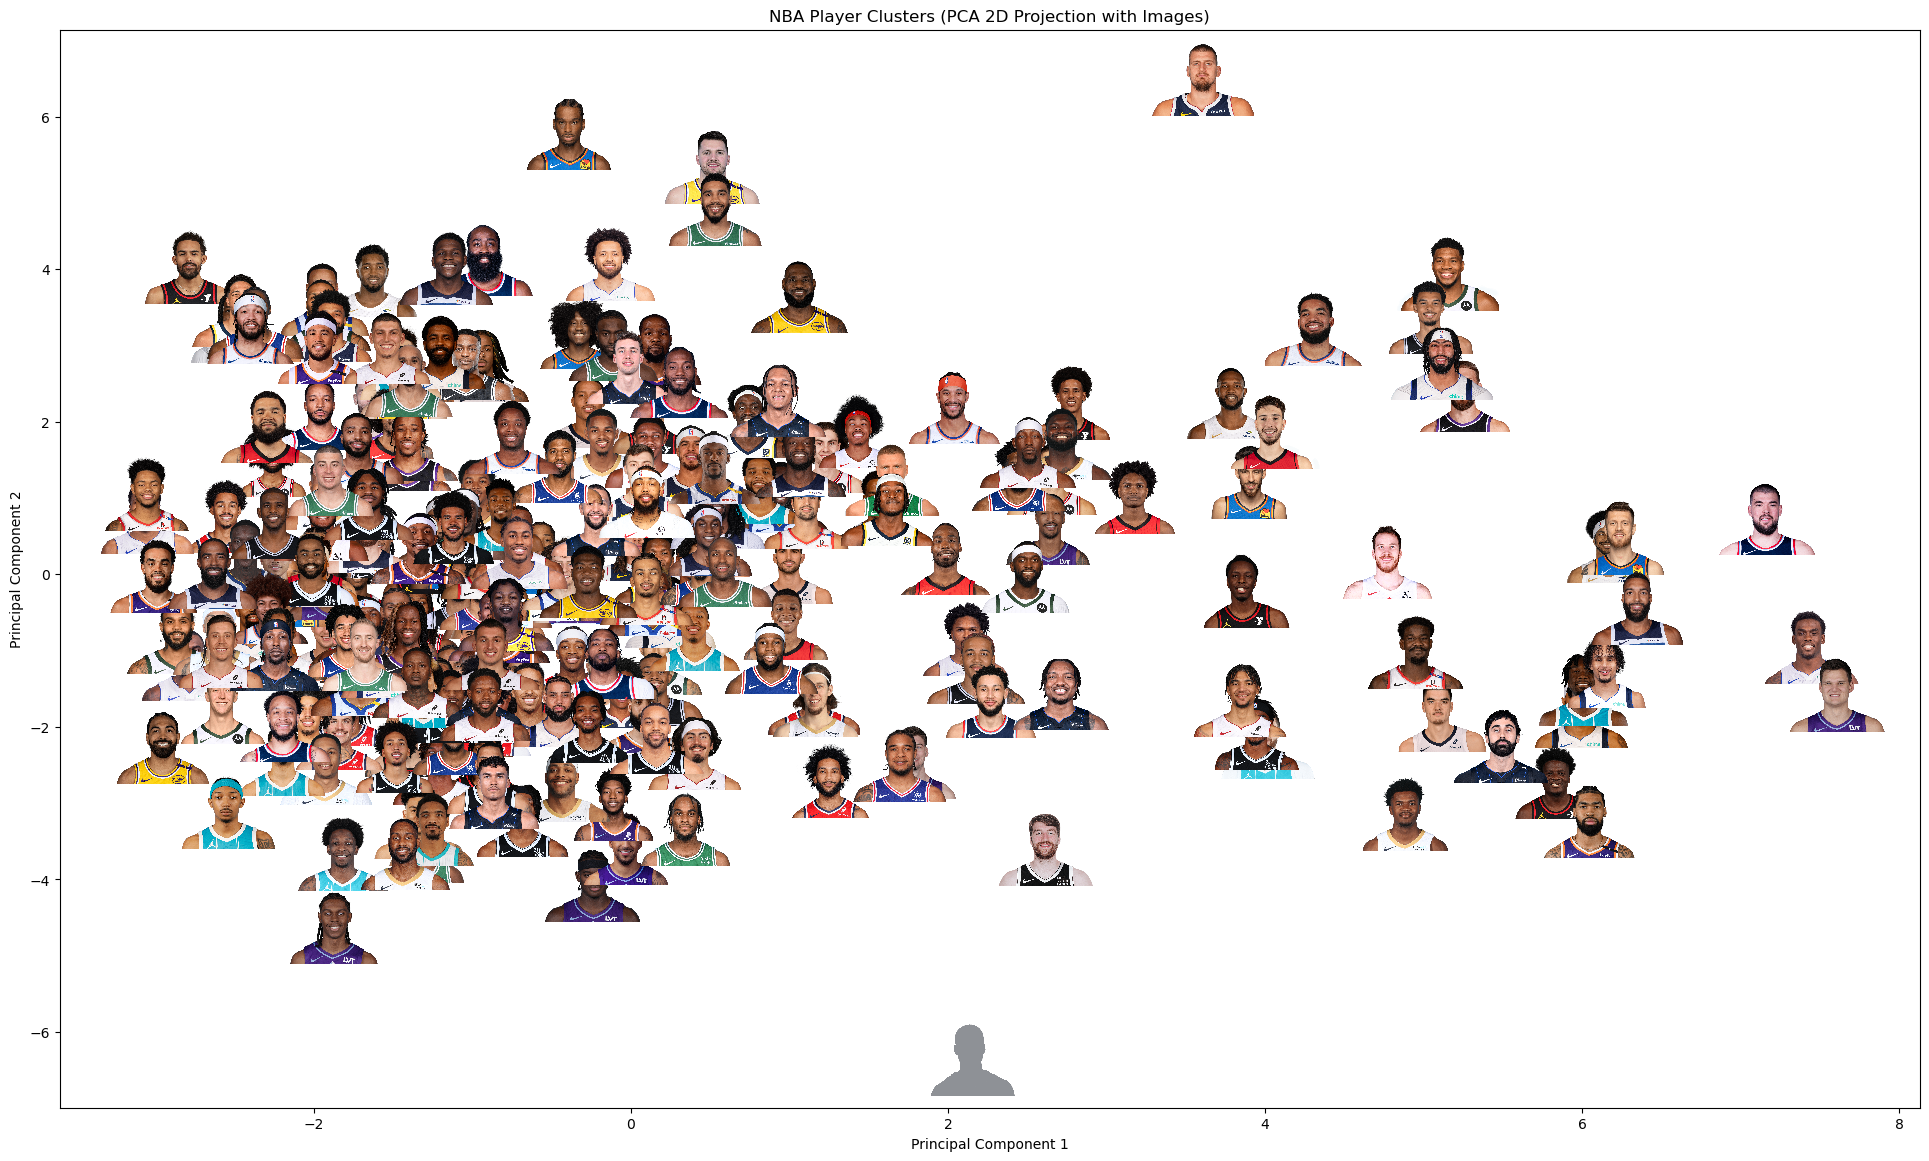

                  PLAYER_NAME  Cluster  DistanceFromCentroid
80                Jalen Duren        0              2.544329
190              Jusuf Nurkić        0              4.855194
194               Ivica Zubac        0              3.458177
162          Dereck Lively II        0              3.389637
154                Yves Missi        0              3.121342
55              Jarrett Allen        0              3.659648
219             Nick Richards        0              3.567398
84             Daniel Gafford        0              3.129926
17                  Zach Edey        0              4.050033
225               Rudy Gobert        0              2.857059
237               Nic Claxton        0              3.156251
185             Deandre Ayton        0              2.594970
238               Kel'el Ware        0              3.313023
254              Goga Bitadze        0              2.525598
118             Mark Williams        0              2.888378
117            Walker Ke

In [166]:
# NBA K-Means Clustering with Elbow Method and Outlier Analysis

from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.offsetbox as offsetbox
from io import BytesIO
import requests
import time
import numpy as np

# ------------------------------
# Data Fetching and Preprocessing
# ------------------------------

metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]
time.sleep(0.6)
player_data = LeagueDashPlayerStats().get_data_frames()[0]
time.sleep(0.6)

metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING",
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")
merged_data = merged_data[merged_data["MIN"] >= 20].reset_index(drop=True)

merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

merged_data = merged_data.drop(columns=["PTS", "GP", "REB", "BLK", "STL", "AST"])
merged_data_numerical = merged_data.drop(columns=["PLAYER_NAME", "PLAYER_ID"])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data_numerical)
scaled_df = pd.DataFrame(scaled_features, columns=merged_data_numerical.columns)

# ------------------------------
# Elbow Method for Optimal Clusters
# ------------------------------

inertias = []
k_range = range(1, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_ / len(scaled_features))

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method: Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Distance from Centroid")
plt.xticks(k_range)
plt.grid(True)
plt.show()

# ------------------------------
# Apply Final KMeans Clustering
# ------------------------------

num_clusters = 8  # <-- Update based on elbow curve
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
merged_data["Cluster"] = kmeans.fit_predict(scaled_features)

# ------------------------------
# PCA for Visualization
# ------------------------------

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(pca_features, columns=["PC1", "PC2"], index=merged_data.index)
pca_df = pd.concat([pca_df, merged_data[["PLAYER_NAME", "PLAYER_ID", "Cluster"]]], axis=1)

pca_loadings = pd.DataFrame(pca.components_.T, index=merged_data_numerical.columns, columns=["PC1", "PC2"])
print("\nPCA Loadings (How each stat contributes to PC1 and PC2):")
print(pca_loadings)

# ------------------------------
# Distance from Centroid + Outlier Detection
# ------------------------------

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

distances = []
for i, label in enumerate(labels):
    centroid = centroids[label]
    point = scaled_features[i]
    dist = np.linalg.norm(point - centroid)
    distances.append(dist)

merged_data["DistanceFromCentroid"] = distances
pca_df["DistanceFromCentroid"] = distances

print("\nOutliers by Z-score (> 2.5 SD from centroid):")
for cluster_num in range(num_clusters):
    cluster_subset = merged_data[merged_data["Cluster"] == cluster_num]
    mean_dist = cluster_subset["DistanceFromCentroid"].mean()
    std_dist = cluster_subset["DistanceFromCentroid"].std()

    threshold = mean_dist + 2.5 * std_dist
    outliers = cluster_subset[cluster_subset["DistanceFromCentroid"] > threshold]

    if not outliers.empty:
        print(f"\nCluster {cluster_num} Outliers (Z > 2.5):")
        for _, row in outliers.iterrows():
            z = (row["DistanceFromCentroid"] - mean_dist) / std_dist
            print(f"  {row['PLAYER_NAME']} - Distance: {row['DistanceFromCentroid']:.2f} (Z = {z:.2f})")

# ------------------------------
# Plot PCA Clusters with Player Images
# ------------------------------

def get_player_image(player_id):
    return f"https://cdn.nba.com/headshots/nba/latest/1040x760/{player_id}.png"

plt.figure(figsize=(24, 14))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", alpha=0.7, legend=False)

ax = plt.gca()
for i, row in pca_df.iterrows():
    player_id = int(row["PLAYER_ID"])
    image_url = get_player_image(player_id)

    try:
        img_response = requests.get(image_url)
        img = plt.imread(BytesIO(img_response.content))
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img, zoom=0.07), (row["PC1"], row["PC2"]), frameon=False)
        ax.add_artist(imagebox)
    except Exception as e:
        print(f"Error fetching image for {row['PLAYER_NAME']} (ID: {player_id}): {e}")

plt.title("NBA Player Clusters (PCA 2D Projection with Images)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# ------------------------------
# Display Player Clusters
# ------------------------------

ordered_df = merged_data[["PLAYER_NAME", "Cluster", "DistanceFromCentroid"]].sort_values(by="Cluster")
pd.set_option('display.max_rows', None)
print(ordered_df)


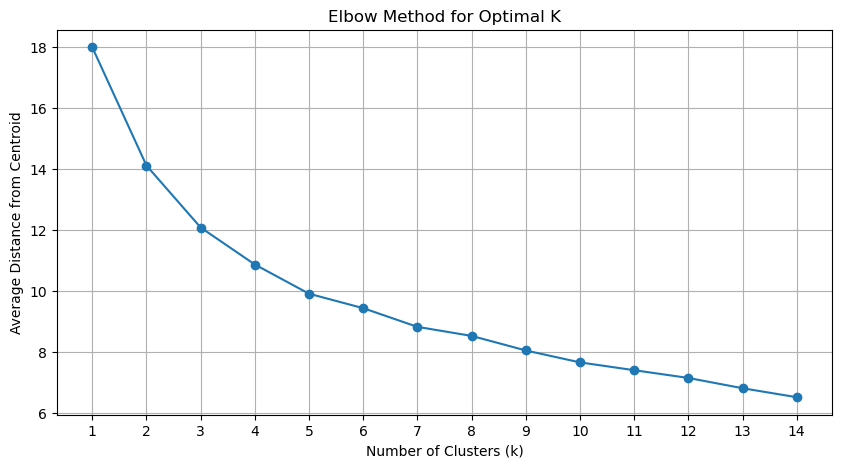


PCA Loadings (How each stat contributes to PC1 and PC2):
                   PC1       PC2
MIN          -0.116878  0.303898
E_OFF_RATING -0.024030  0.339557
E_DEF_RATING -0.094217 -0.142456
E_NET_RATING  0.039025  0.316877
E_AST_RATIO  -0.132762  0.260268
E_OREB_PCT    0.391194  0.016746
E_DREB_PCT    0.350996  0.199198
E_REB_PCT     0.389754  0.154945
E_TOV_PCT     0.120371  0.075187
E_USG_PCT    -0.112122  0.333059
FG3M         -0.295035  0.122815
FG3_PCT      -0.248597  0.051719
FG_PCT        0.308487  0.128893
PPG          -0.111298  0.409151
RPG           0.372776  0.196537
BPG           0.267698  0.021367
SPG          -0.088640  0.169550
APG          -0.166307  0.392106

Outliers by Z-score (> 2.5 SD from centroid):


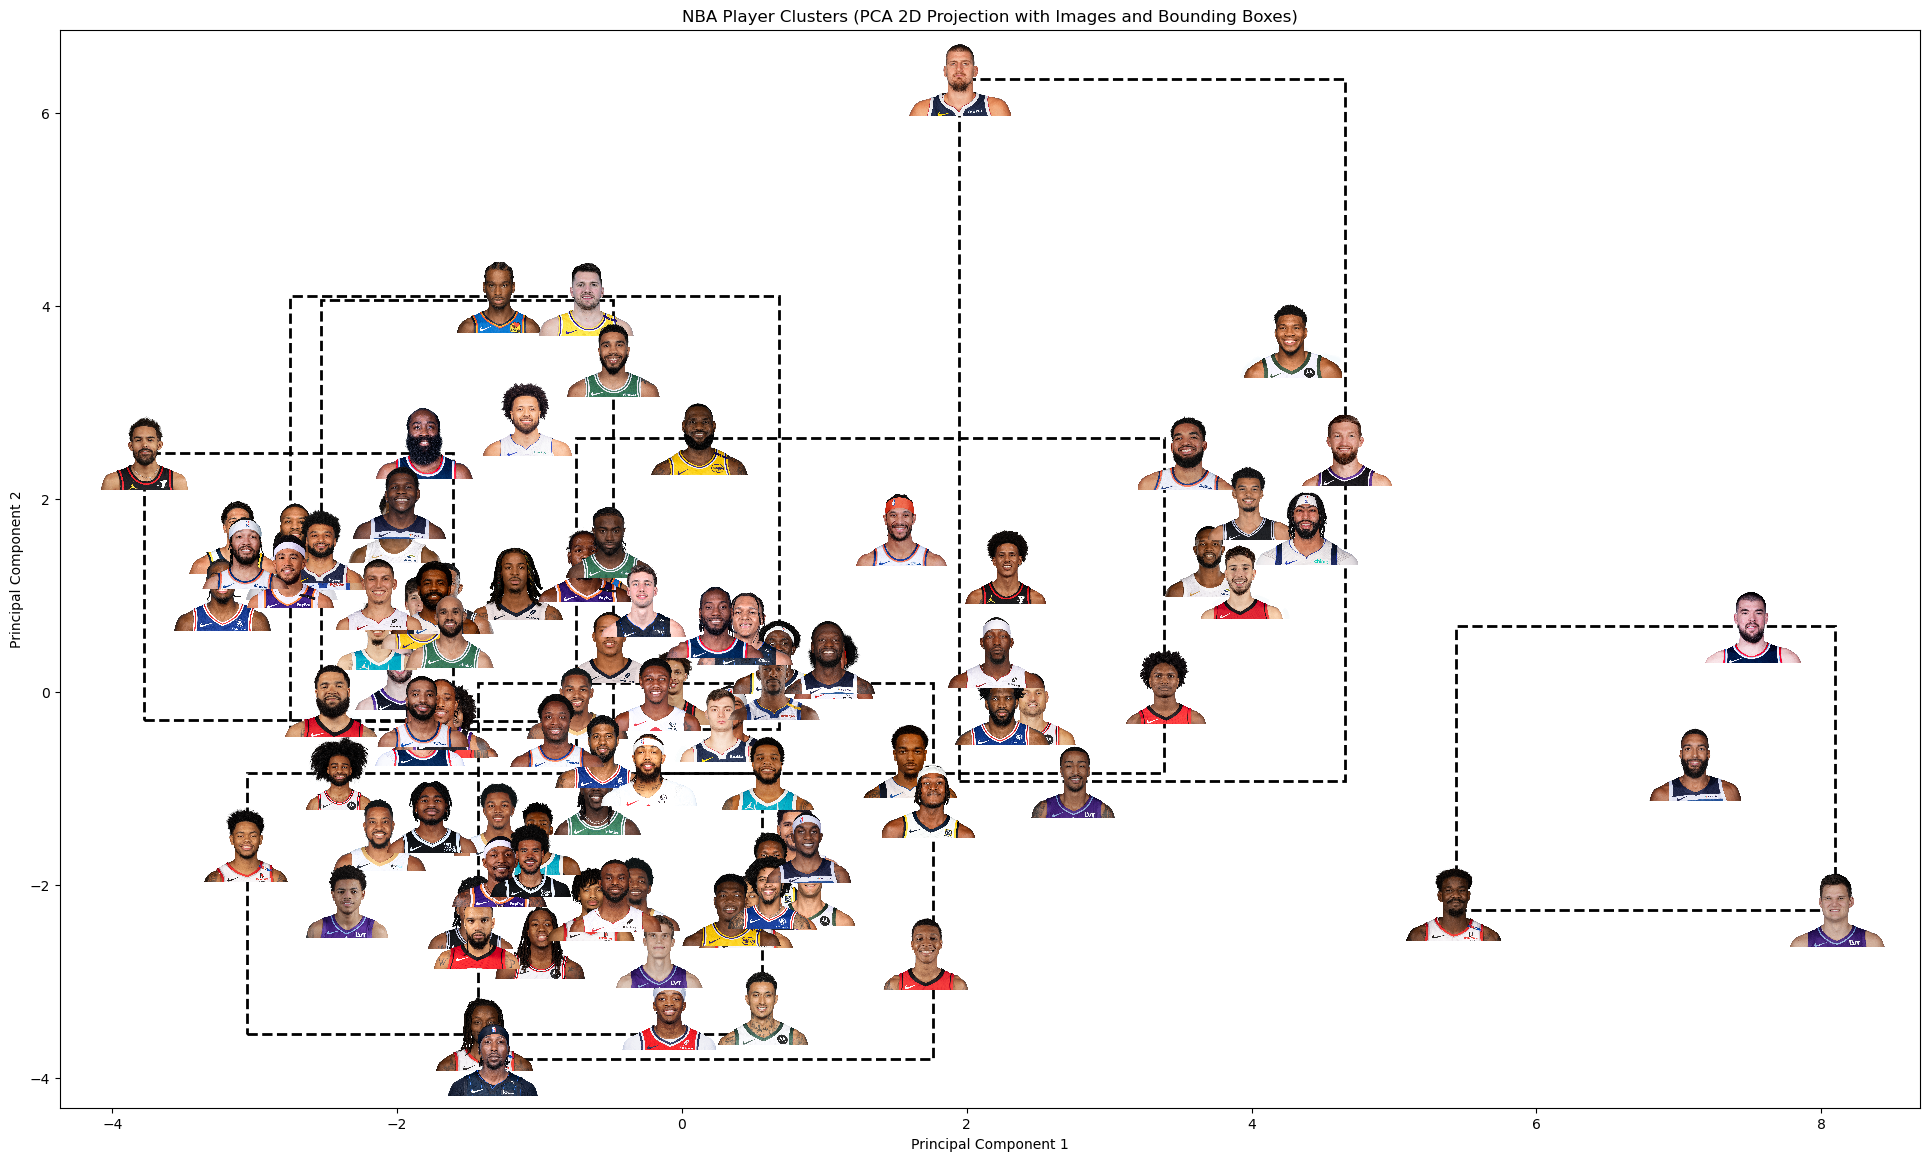

                  PLAYER_NAME  Cluster  DistanceFromCentroid
78               Jayson Tatum        0              2.685748
89              Derrick White        0              3.414313
45                Jalen Green        0              2.506163
47                Luka Dončić        0              3.419220
18            Cade Cunningham        0              2.643050
16                Zach LaVine        0              2.758784
98                Tyler Herro        0              1.675857
17              Stephen Curry        0              2.034982
73               Kevin Durant        0              3.316370
69               James Harden        0              2.987392
81            Anthony Edwards        0              1.913287
8             Bilal Coulibaly        1              3.546578
92            Cameron Johnson        1              1.196927
37              Devin Vassell        1              1.890160
30            Lauri Markkanen        1              2.697553
38               Jerami 

In [156]:
# NBA K-Means Clustering with Elbow Method, Outlier Detection, and Bounding Boxes

from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.offsetbox as offsetbox
from io import BytesIO
import requests
import time
import numpy as np

# ------------------------------
# Data Fetching and Preprocessing
# ------------------------------

metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]
time.sleep(0.6)
player_data = LeagueDashPlayerStats().get_data_frames()[0]
time.sleep(0.6)

metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")
merged_data = merged_data[merged_data["MIN"] >= 30].reset_index(drop=True)

merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

merged_data = merged_data.drop(columns=["PTS", "GP", "REB", "BLK", "STL", "AST"])
merged_data_numerical = merged_data.drop(columns=["PLAYER_NAME", "PLAYER_ID"])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data_numerical)
scaled_df = pd.DataFrame(scaled_features, columns=merged_data_numerical.columns)

# ------------------------------
# Elbow Method: Choose Optimal k
# ------------------------------

inertias = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_ / len(scaled_features))

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Distance from Centroid")
plt.xticks(k_range)
plt.grid(True)
plt.show()

# ------------------------------
# Choose Final Number of Clusters
# ------------------------------

num_clusters = 8  # Update based on elbow method
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
merged_data["Cluster"] = kmeans.fit_predict(scaled_features)

# ------------------------------
# PCA for Visualization
# ------------------------------

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(pca_features, columns=["PC1", "PC2"], index=merged_data.index)
pca_df = pd.concat([pca_df, merged_data[["PLAYER_NAME", "PLAYER_ID", "Cluster"]]], axis=1)

pca_loadings = pd.DataFrame(pca.components_.T, index=merged_data_numerical.columns, columns=["PC1", "PC2"])
print("\nPCA Loadings (How each stat contributes to PC1 and PC2):")
print(pca_loadings)

# ------------------------------
# Distance from Centroid + Z-Score Outlier Detection
# ------------------------------

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

distances = []
for i, label in enumerate(labels):
    centroid = centroids[label]
    point = scaled_features[i]
    dist = np.linalg.norm(point - centroid)
    distances.append(dist)

merged_data["DistanceFromCentroid"] = distances
pca_df["DistanceFromCentroid"] = distances

print("\nOutliers by Z-score (> 2.5 SD from centroid):")
for cluster_num in range(num_clusters):
    cluster_subset = merged_data[merged_data["Cluster"] == cluster_num]
    mean_dist = cluster_subset["DistanceFromCentroid"].mean()
    std_dist = cluster_subset["DistanceFromCentroid"].std()

    threshold = mean_dist + 2.5 * std_dist
    outliers = cluster_subset[cluster_subset["DistanceFromCentroid"] > threshold]

    if not outliers.empty:
        print(f"\nCluster {cluster_num} Outliers (Z > 2.5):")
        for _, row in outliers.iterrows():
            z = (row["DistanceFromCentroid"] - mean_dist) / std_dist
            print(f"  {row['PLAYER_NAME']} - Distance: {row['DistanceFromCentroid']:.2f} (Z = {z:.2f})")

# ------------------------------
# Plot PCA Clusters with Bounding Boxes and Player Images
# ------------------------------

def get_player_image(player_id):
    return f"https://cdn.nba.com/headshots/nba/latest/1040x760/{player_id}.png"

plt.figure(figsize=(24, 14))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", alpha=0.7, legend=False)

ax = plt.gca()
for i, row in pca_df.iterrows():
    player_id = int(row["PLAYER_ID"])
    image_url = get_player_image(player_id)
    try:
        img_response = requests.get(image_url)
        img = plt.imread(BytesIO(img_response.content))
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img, zoom=0.07), (row["PC1"], row["PC2"]), frameon=False)
        ax.add_artist(imagebox)
    except Exception as e:
        print(f"Error fetching image for {row['PLAYER_NAME']} (ID: {player_id}): {e}")

# Add bounding boxes around each cluster
for cluster_id in range(num_clusters):
    cluster_data = pca_df[pca_df["Cluster"] == cluster_id]
    x_min, x_max = cluster_data["PC1"].min(), cluster_data["PC1"].max()
    y_min, y_max = cluster_data["PC2"].min(), cluster_data["PC2"].max()
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=2, edgecolor="black", facecolor="none", linestyle="--")
    ax.add_patch(rect)

plt.title("NBA Player Clusters (PCA 2D Projection with Images and Bounding Boxes)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# ------------------------------
# Display Player Clusters
# ------------------------------

ordered_df = merged_data[["PLAYER_NAME", "Cluster", "DistanceFromCentroid"]].sort_values(by="Cluster")
pd.set_option('display.max_rows', None)
print(ordered_df)


In [140]:
from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats
import pandas as pd
import time  # For rate-limiting
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]
time.sleep(0.6)  # Delay to prevent rate limits

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]
time.sleep(0.6)  # Delay to prevent rate limits

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING", 
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

# Merge datasets on PLAYER_ID
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")

# Filter for players who play at least 20 minutes per game
merged_data = merged_data[merged_data["MIN"] >= 20].reset_index(drop=True)

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

# Drop unnecessary columns (keeping only per-game stats)
merged_data = merged_data.drop(columns=["PTS", "GP", "REB", "BLK", "STL", "AST"])

# Drop non-numeric columns before scaling
merged_data_numerical = merged_data.drop(columns=["PLAYER_NAME", "PLAYER_ID"])

# Drop non-numeric columns before scaling
#merged_data_numerical = merged_data.select_dtypes(include=['number'])

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data_numerical)

# Apply K-Means clustering
num_clusters = 10  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
merged_data_numerical["Cluster"] = kmeans.fit_predict(scaled_features)

# Cluster profile description: Calculate the mean for each feature by cluster
cluster_summary = merged_data_numerical.groupby("Cluster").mean()
print("\nCluster Summary (Average values of features per cluster):")
print(cluster_summary)


# Calculate overall mean and std for each feature
overall_mean = merged_data_numerical.drop(columns=["Cluster"]).mean()
overall_std = merged_data_numerical.drop(columns=["Cluster"]).std()

# Describe the top/bottom defining features for each cluster based on Z-score
print("\nTop 3 and Bottom 3 defining features (Z-scores) for each cluster:")
for cluster_num in range(num_clusters):
    cluster_means = cluster_summary.loc[cluster_num]
    z_scores = (cluster_means - overall_mean) / overall_std

    # Invert Z-scores for stats where lower is better
    invert_stats = ["E_TOV_PCT", "E_DEF_RATING"]  # Add others as needed
    z_scores[invert_stats] = -z_scores[invert_stats]


    top_3 = z_scores.sort_values(ascending=False).head(3)
    bottom_3 = z_scores.sort_values(ascending=True).head(3)

    print(f"\nCluster {cluster_num}:")
    print("  Top 3 Features:")
    for feature, z in top_3.items():
        print(f"    • {feature}: {z:.2f} SD above mean")

    print("  Bottom 3 Features:")
    for feature, z in bottom_3.items():
        print(f"    • {feature}: {z:.2f} SD below mean")

            
# Merge the cluster column back to the original data to include PLAYER_NAME
merged_data["Cluster"] = merged_data_numerical["Cluster"]

# Sort by Cluster and display player names along with clusters
ordered_df = merged_data[["PLAYER_NAME", "Cluster"]].sort_values(by="Cluster")

# Display sorted DataFrame with only PLAYER_NAME and Cluster
pd.set_option('display.max_rows', None)  # Show all rows
print(ordered_df)


Cluster Summary (Average values of features per cluster):
               MIN  E_OFF_RATING  E_DEF_RATING  E_NET_RATING  E_AST_RATIO  \
Cluster                                                                     
0        25.356250    111.178125    110.037500      1.137500    29.143750   
1        24.127778    104.455556    115.230556    -10.775000    15.858333   
2        26.593333    111.220000    112.033333     -0.806667    16.266667   
3        25.088636    114.336364    110.759091      3.581818    15.800000   
4        30.171429    108.717857    115.021429     -6.321429    16.557143   
5        32.593333    114.313333    110.353333      3.946667    18.060000   
6        31.150000    114.631818    110.177273      4.463636    12.963636   
7        32.840909    112.195455    110.409091      1.781818    22.627273   
8        24.125000    110.131250    113.468750     -3.350000    16.168750   
9        34.725000    115.382143    112.260714      3.103571    20.614286   

         E_OREB_


Cluster Summary (Average values per cluster, in original scale):
               MIN  E_OFF_RATING  E_DEF_RATING  E_NET_RATING  E_AST_RATIO  \
Cluster                                                                     
0        25.356250    111.178125    110.037500      1.137500    29.143750   
1        24.127778    104.455556    115.230556    -10.775000    15.858333   
2        26.593333    111.220000    112.033333     -0.806667    16.266667   
3        25.088636    114.336364    110.759091      3.581818    15.800000   
4        30.171429    108.717857    115.021429     -6.321429    16.557143   
5        32.593333    114.313333    110.353333      3.946667    18.060000   
6        31.150000    114.631818    110.177273      4.463636    12.963636   
7        32.840909    112.195455    110.409091      1.781818    22.627273   
8        24.125000    110.131250    113.468750     -3.350000    16.168750   
9        34.725000    115.382143    112.260714      3.103571    20.614286   

         

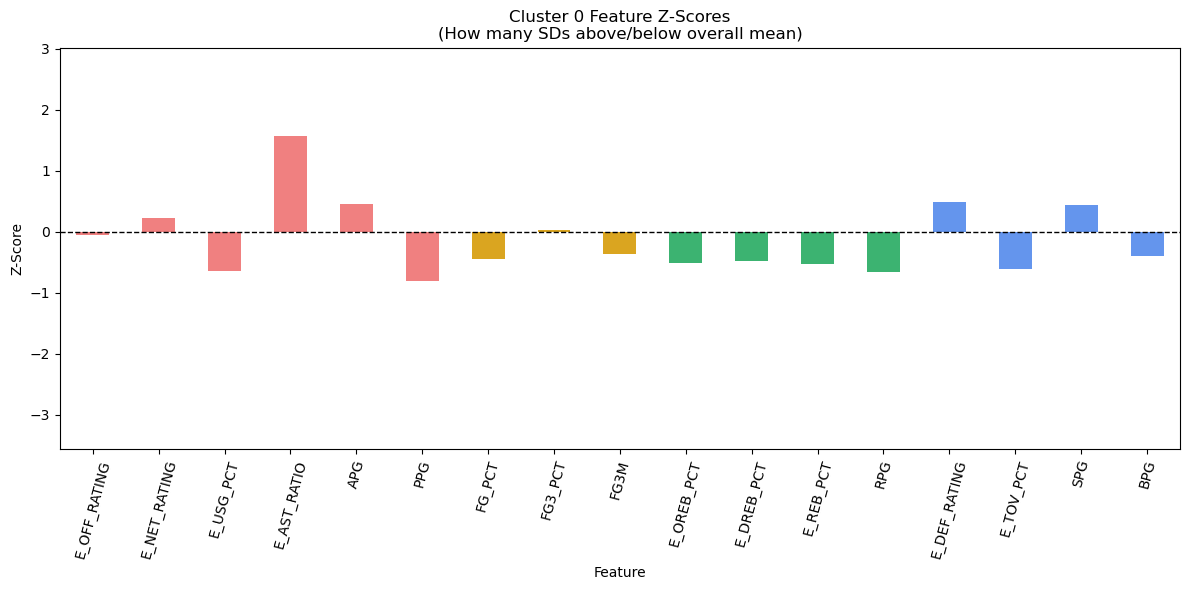

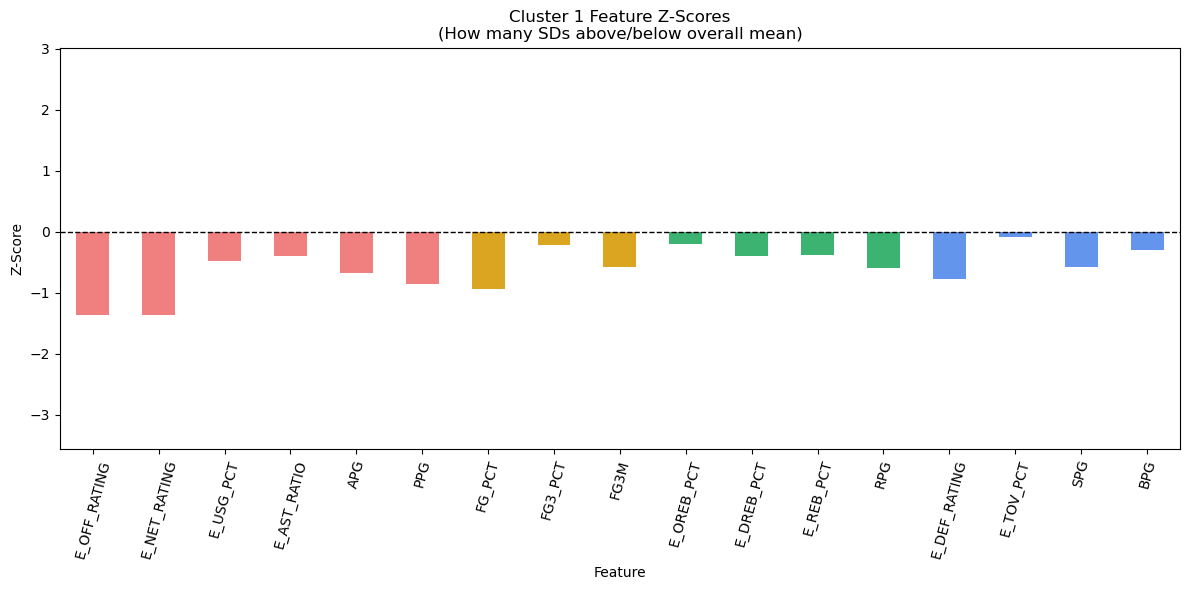

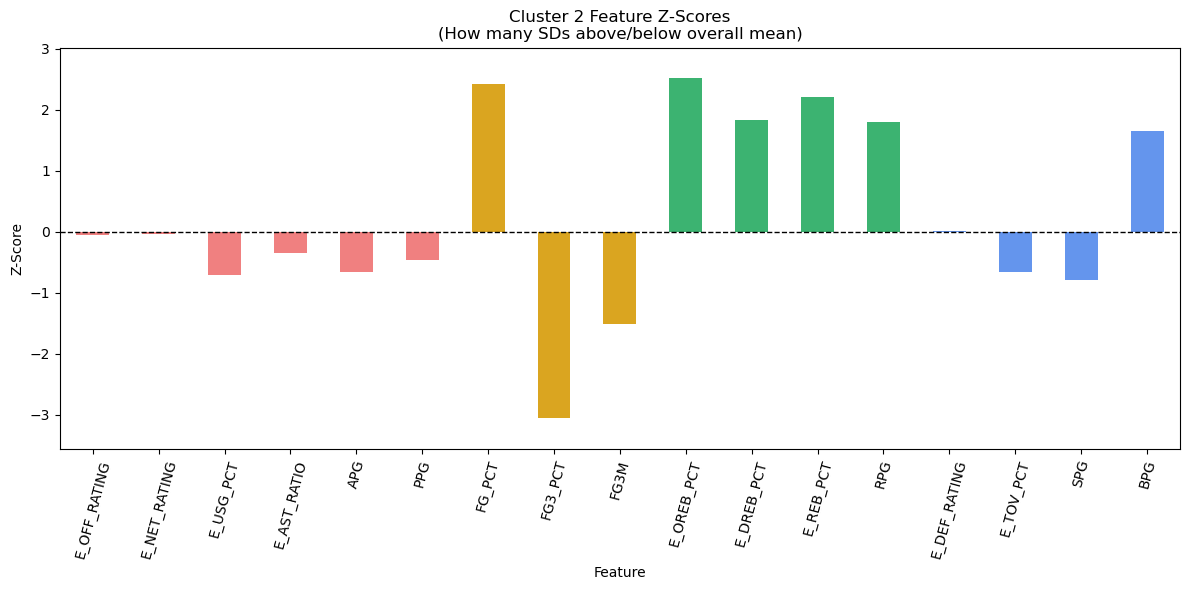

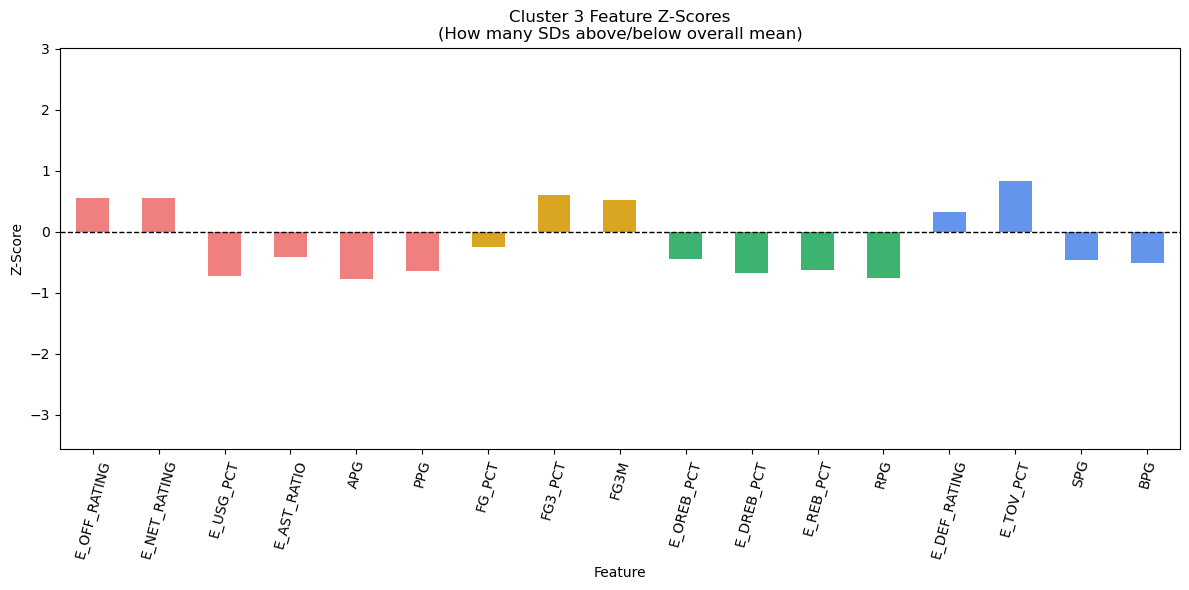

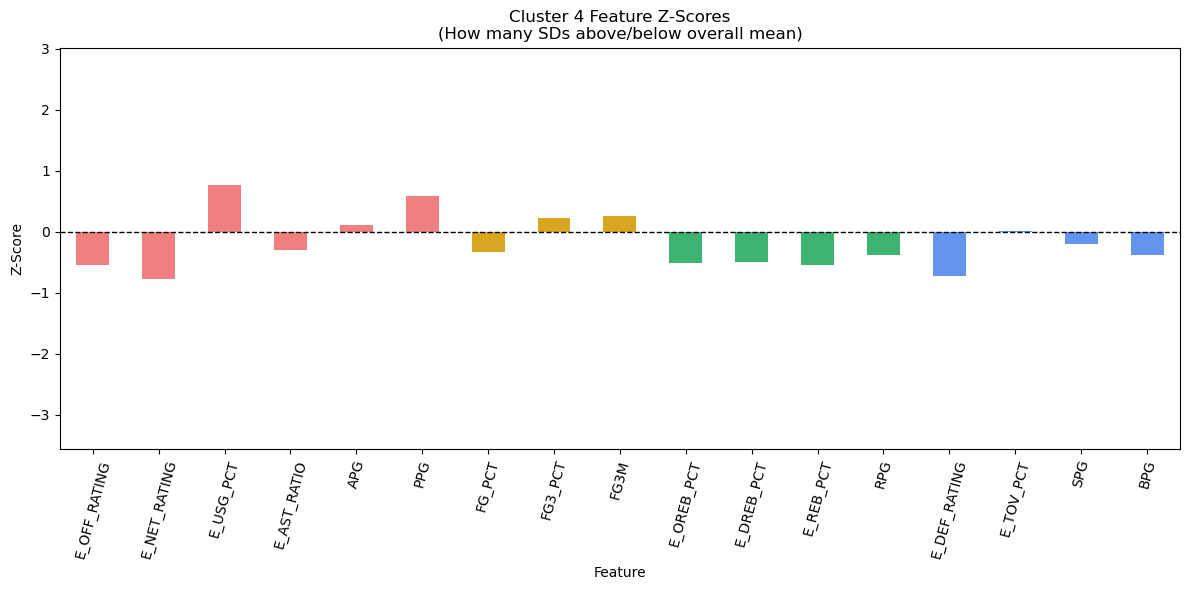

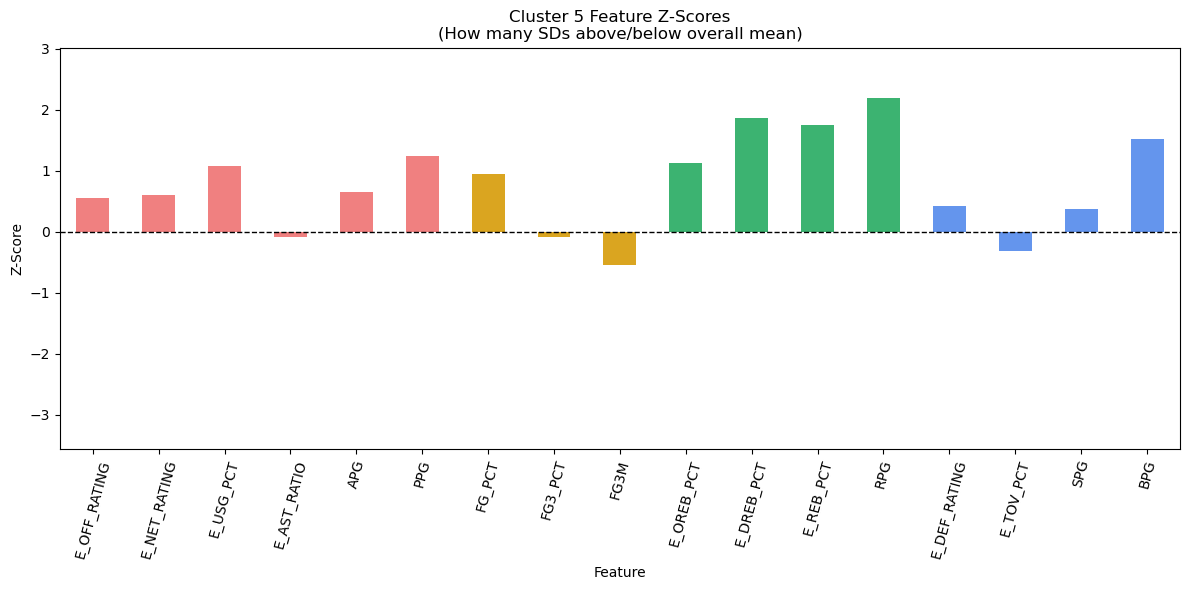

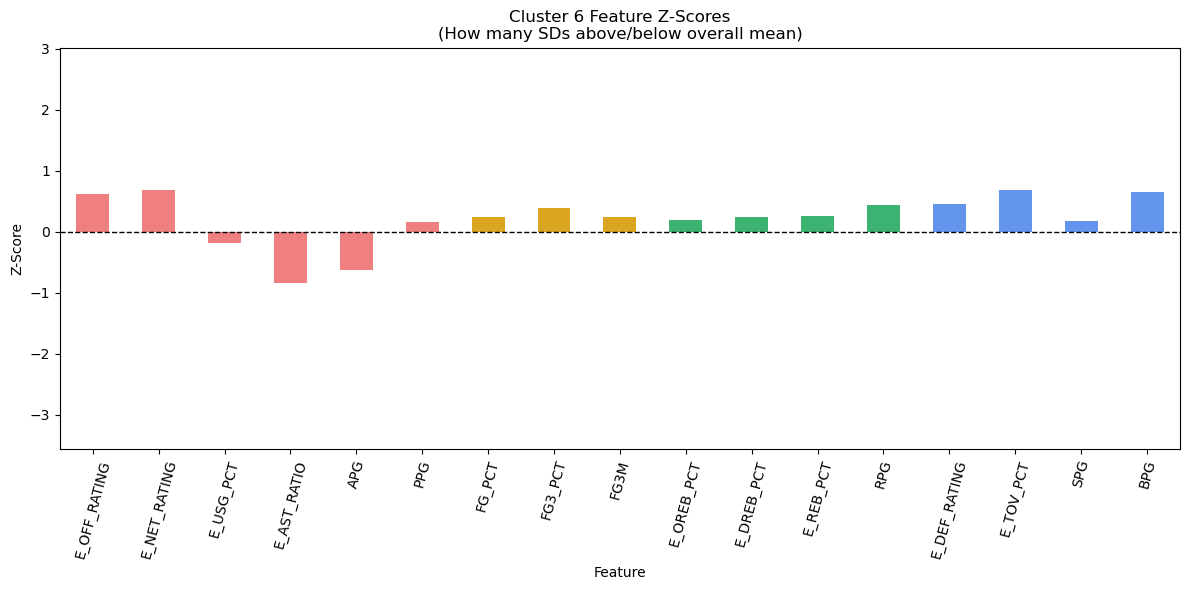

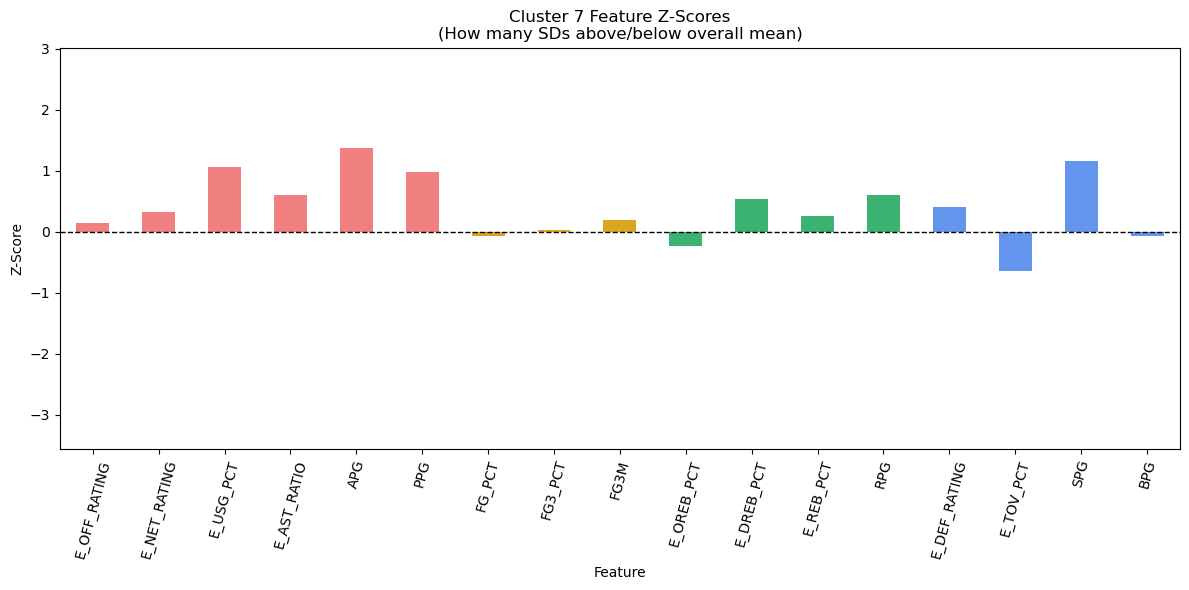

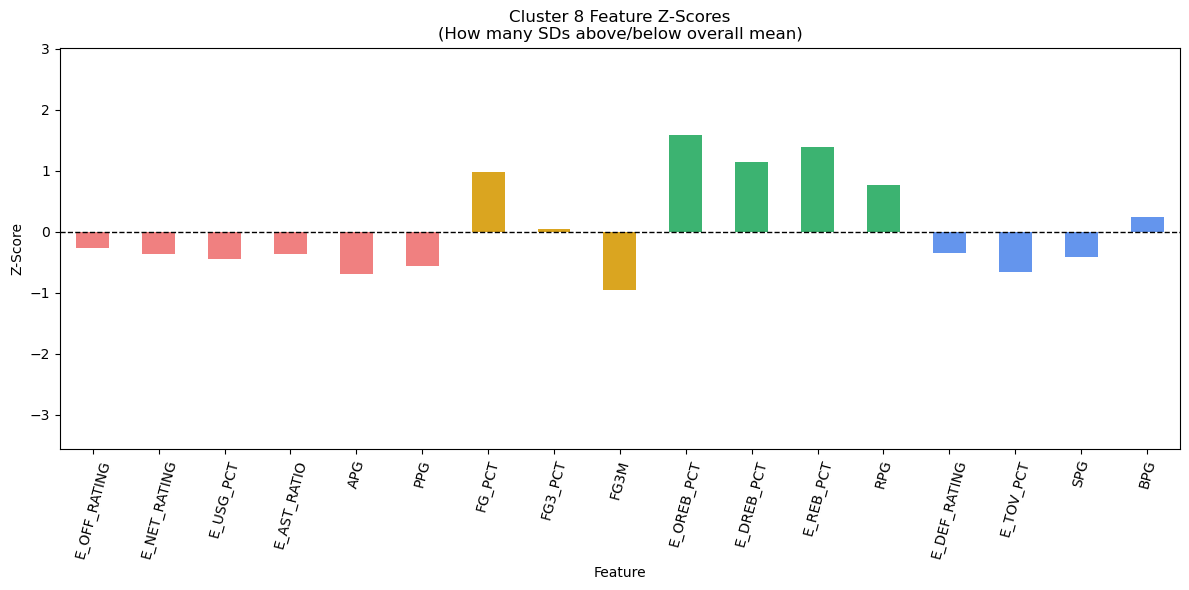

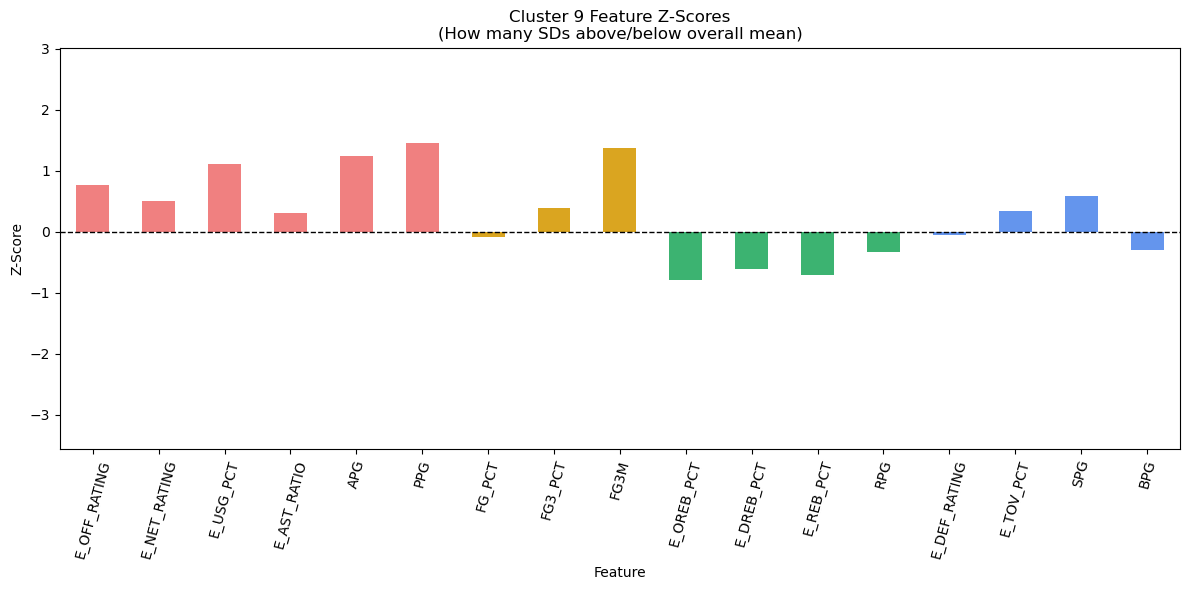

                  PLAYER_NAME  Cluster
128          Donte DiVincenzo        0
27               Jake LaRavia        0
56             Isaiah Collier        0
169              Jrue Holiday        0
166             Elfrid Payton        0
161             Jose Alvarado        0
151          D'Angelo Russell        0
149            Grant Williams        0
142                Chris Paul        0
26            Khris Middleton        0
134        Brandin Podziemski        0
130           Dennis Schröder        0
111           Andrew Nembhard        0
108         Spencer Dinwiddie        0
107               Cody Martin        0
97            Scoot Henderson        0
86              Herbert Jones        0
73             Draymond Green        0
61              Cason Wallace        0
41                 Vít Krejčí        0
184                 Kris Dunn        0
58              Killian Hayes        0
5           Scotty Pippen Jr.        0
10               Luke Kennard        0
21          De'Anthony Me

In [164]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from nba_api.stats.endpoints import PlayerEstimatedMetrics, LeagueDashPlayerStats

# ------------------------------
# Data Fetching and Preprocessing
# ------------------------------

# Fetch estimated metrics data
metrics_data = PlayerEstimatedMetrics(season="2024-25", season_type="Regular Season").get_data_frames()[0]
time.sleep(0.6)

# Fetch general player stats
player_data = LeagueDashPlayerStats().get_data_frames()[0]
time.sleep(0.6)

# Select relevant columns
metrics_columns = ["PLAYER_ID", "PLAYER_NAME", "MIN", "E_OFF_RATING", "E_DEF_RATING", "E_NET_RATING",
                   "E_AST_RATIO", "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "E_TOV_PCT", "E_USG_PCT"]
stats_columns = ["PLAYER_ID", "FG3M", "FG3_PCT", "FG_PCT", "GP", "PTS", "REB", "BLK", "STL", "AST"]

# Merge datasets on PLAYER_ID
merged_data = pd.merge(metrics_data[metrics_columns], player_data[stats_columns], on="PLAYER_ID")

# Filter for players who play at least 20 minutes per game
merged_data = merged_data[merged_data["MIN"] >= 20].reset_index(drop=True)

# Compute per-game stats
merged_data["PPG"] = merged_data["PTS"] / merged_data["GP"]
merged_data["RPG"] = merged_data["REB"] / merged_data["GP"]
merged_data["BPG"] = merged_data["BLK"] / merged_data["GP"]
merged_data["SPG"] = merged_data["STL"] / merged_data["GP"]
merged_data["APG"] = merged_data["AST"] / merged_data["GP"]

# Drop unnecessary columns
merged_data_numerical = merged_data.drop(columns=["PLAYER_ID", "PTS", "GP", "REB", "BLK", "STL", "AST"])

# ------------------------------
# Clustering on Numeric Data
# ------------------------------

# Remove non-numeric column
cluster_df = merged_data_numerical.drop(columns=["PLAYER_NAME"])

# Standardize
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_df)

# KMeans Clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
merged_data_numerical["Cluster"] = kmeans.fit_predict(scaled_features)

# ------------------------------
# Cluster Summary
# ------------------------------

numeric_columns = merged_data_numerical.select_dtypes(include=[np.number]).columns
cluster_summary = merged_data_numerical[numeric_columns].groupby("Cluster").mean()
print("\nCluster Summary (Average values per cluster, in original scale):")
print(cluster_summary)

# ------------------------------
# Z-Score Analysis
# ------------------------------

# Define which columns to analyze
analysis_columns = merged_data_numerical.columns.difference(["PLAYER_NAME", "Cluster"])

# Compute overall stats
overall_means = merged_data_numerical[analysis_columns].mean()
overall_stds = merged_data_numerical[analysis_columns].std()

# Prepare for plotting
all_z_scores = []
invert_stats = ["E_TOV_PCT", "E_DEF_RATING"]

# Compute Z-scores for each cluster
for cluster_num in range(num_clusters):
    cluster_data = merged_data_numerical[merged_data_numerical["Cluster"] == cluster_num]
    cluster_means = cluster_data[analysis_columns].mean()
    cluster_z_scores = (cluster_means - overall_means) / overall_stds

    for stat in invert_stats:
        if stat in cluster_z_scores:
            cluster_z_scores[stat] *= -1

    all_z_scores.append(cluster_z_scores)

# Find global Y-axis limits
all_z_scores_df = pd.DataFrame(all_z_scores)
min_y = all_z_scores_df.min().min() - 0.5
max_y = all_z_scores_df.max().max() + 0.5

# Define ordered categories and their corresponding colors
category_order = [
    "E_OFF_RATING", "E_NET_RATING", "E_USG_PCT", "E_AST_RATIO", "APG", "PPG",         # Offense
    "FG_PCT", "FG3_PCT", "FG3M",                                                      # Shooting
    "E_OREB_PCT", "E_DREB_PCT", "E_REB_PCT", "RPG",                                   # Rebounding
    "E_DEF_RATING", "E_TOV_PCT", "SPG", "BPG"                                         # Defense
]

category_colors = {
    "E_OFF_RATING": "lightcoral", "E_NET_RATING": "lightcoral", "E_USG_PCT": "lightcoral",
    "E_AST_RATIO": "lightcoral", "APG": "lightcoral", "PPG": "lightcoral",
    
    "FG_PCT": "goldenrod", "FG3_PCT": "goldenrod", "FG3M": "goldenrod",
    
    "E_OREB_PCT": "mediumseagreen", "E_DREB_PCT": "mediumseagreen",
    "E_REB_PCT": "mediumseagreen", "RPG": "mediumseagreen",
    
    "E_DEF_RATING": "cornflowerblue", "E_TOV_PCT": "cornflowerblue",
    "SPG": "cornflowerblue", "BPG": "cornflowerblue"
}

# Plot Z-scores with color-coded bars
for cluster_num, cluster_z_scores in enumerate(all_z_scores):
    plt.figure(figsize=(12, 6))
    ordered_z_scores = cluster_z_scores[category_order]
    bar_colors = [category_colors[stat] for stat in category_order]

    ordered_z_scores.plot(kind="bar", color=bar_colors)
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"Cluster {cluster_num} Feature Z-Scores\n(How many SDs above/below overall mean)")
    plt.xlabel("Feature")
    plt.ylabel("Z-Score")
    plt.xticks(rotation=75)
    plt.ylim(min_y, max_y)
    plt.tight_layout()
    plt.show()


# ------------------------------
# Display Player Names by Cluster
# ------------------------------

merged_data["Cluster"] = merged_data_numerical["Cluster"]
ordered_df = merged_data[["PLAYER_NAME", "Cluster"]].sort_values(by="Cluster")
pd.set_option('display.max_rows', None)
print(ordered_df)


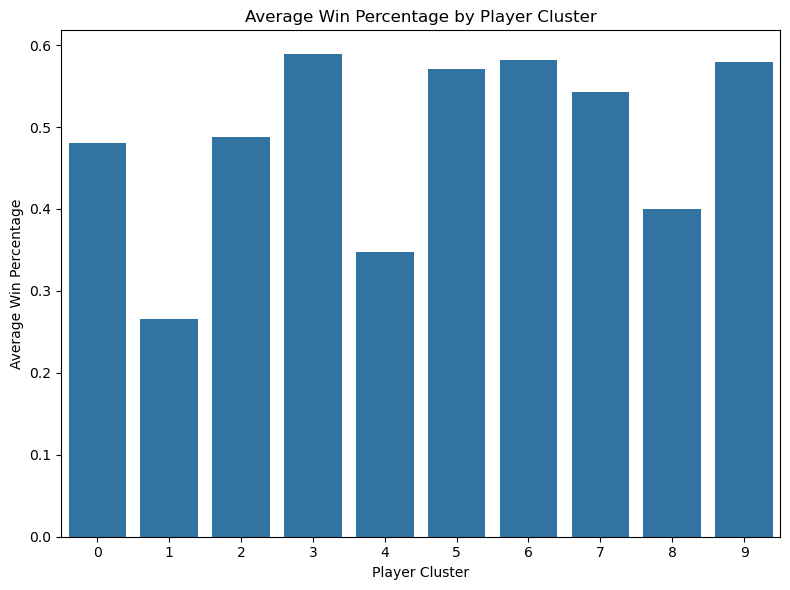

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import LeagueDashPlayerStats

# Fetch LeagueDashPlayerStats
league_stats = LeagueDashPlayerStats()

# Convert the data into a pandas DataFrame
league_stats_df = league_stats.get_data_frames()[0]

# Merge the ordered_df with league_stats_df on 'PLAYER_NAME'
merged_df = pd.merge(ordered_df, league_stats_df, on="PLAYER_NAME", how="left")

# Ensure W_PCT is calculated if not present:
if 'W_PCT' not in merged_df.columns:
    merged_df['W_PCT'] = merged_df['W'] / merged_df['GP']

# Now, group by team and cluster to check how the clusters relate to team performance
team_cluster_usage = merged_df.groupby(["TEAM_ABBREVIATION", "Cluster"]).size().unstack(fill_value=0)

# Calculate the average win percentage for teams based on player clusters
team_analysis = merged_df.groupby('TEAM_ABBREVIATION').agg(
    AVG_WIN_PERCENTAGE=('W_PCT', 'mean')  # This will give us the average win percentage for each team
)

# Merge team analysis with the cluster usage data to get a combined analysis
team_analysis = team_analysis.merge(team_cluster_usage, left_index=True, right_index=True, how="left")

'''# Visualize trends: Create a bar plot showing average win percentage per cluster
plt.figure(figsize=(12, 6))
sns.barplot(x=team_analysis.index, y=team_analysis['AVG_WIN_PERCENTAGE'])#, hue=team_analysis['Cluster'])
plt.xticks(rotation=90)
plt.title("Win Percentage by Team and Player Cluster")
plt.xlabel("Team Name")
plt.ylabel("Average Win Percentage")
plt.tight_layout()
plt.show()'''

# For a deeper analysis, you can further explore how clusters correlate with winning trends:
cluster_win_percentage = merged_df.groupby('Cluster')['W_PCT'].mean()

# Plot the win percentage across clusters
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_win_percentage.index, y=cluster_win_percentage.values)
plt.title("Average Win Percentage by Player Cluster")
plt.xlabel("Player Cluster")
plt.ylabel("Average Win Percentage")
plt.tight_layout()
plt.show()


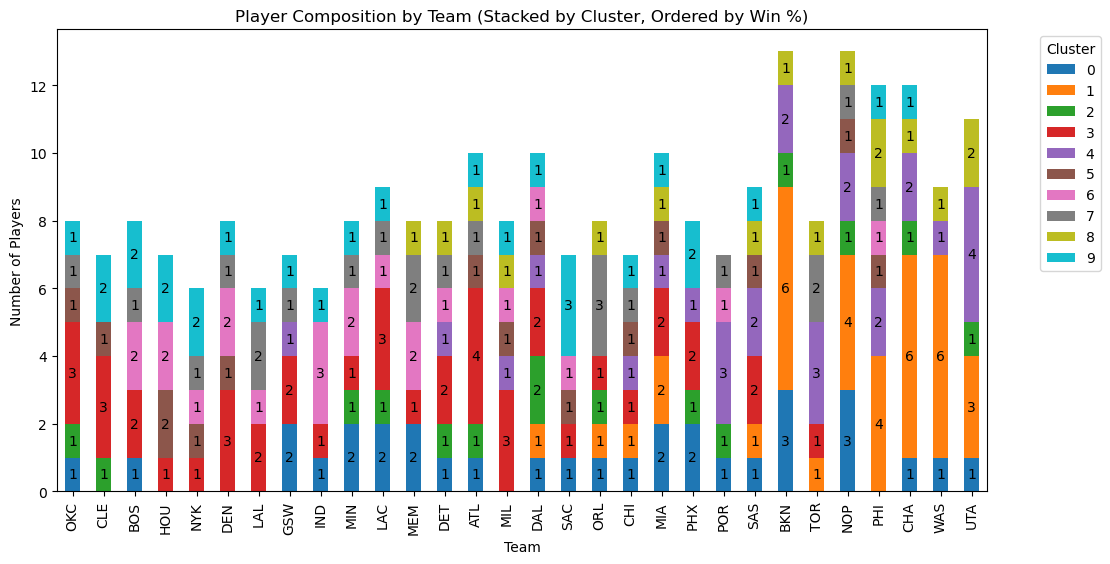

In [146]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import LeagueDashPlayerStats

# Fetch LeagueDashPlayerStats
league_stats = LeagueDashPlayerStats()

# Convert the data into a pandas DataFrame
league_stats_df = league_stats.get_data_frames()[0]

# Merge the ordered_df with league_stats_df on 'PLAYER_NAME'
merged_df = pd.merge(ordered_df, league_stats_df, on="PLAYER_NAME", how="left")

# Calculate the average win percentage for teams
team_win_pct = merged_df.groupby('TEAM_ABBREVIATION').agg(
    AVG_WIN_PERCENTAGE=('W_PCT', 'mean')
).reset_index()

# Count players per cluster for each team
composition_df = merged_df.groupby(['TEAM_ABBREVIATION', 'Cluster']).size().reset_index(name='Player_Count')

# Merge win percentage to order teams
composition_df = composition_df.merge(team_win_pct, on='TEAM_ABBREVIATION')

# Sort teams by win percentage **before pivoting**
composition_df = composition_df.sort_values(by="AVG_WIN_PERCENTAGE", ascending=False)

# Pivot after sorting to maintain order
composition_pivot = composition_df.pivot(index='TEAM_ABBREVIATION', columns='Cluster', values='Player_Count').fillna(0)

# **Re-sort index to maintain win percentage order**
composition_pivot = composition_pivot.loc[team_win_pct.sort_values("AVG_WIN_PERCENTAGE", ascending=False)['TEAM_ABBREVIATION']]

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
composition_pivot.plot(kind='bar', stacked=True, colormap='tab10', ax=ax)

# Add labels to each section of the bars
for i, team in enumerate(composition_pivot.index):
    bottom = 0  # Keeps track of cumulative height
    for cluster in composition_pivot.columns:
        value = composition_pivot.loc[team, cluster]
        if value > 0:
            ax.text(i, bottom + value / 2, str(int(value)), ha='center', va='center', fontsize=10, color='black')
            bottom += value

# Formatting the chart
plt.title("Player Composition by Team (Stacked by Cluster, Ordered by Win %)")
plt.xlabel("Team")
plt.ylabel("Number of Players")
plt.xticks(rotation=90)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
